<a href="https://colab.research.google.com/github/jyanivaddi/ERA_V1/blob/master/session_10/s10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone "https://github.com/jyanivaddi/ERA_V1.git"
!git pull
!pip install torchinfo
!pip install prettytable
!pip install torch_lr_finder

Cloning into 'ERA_V1'...
remote: Enumerating objects: 790, done.
remote: Counting objects: 100% (255/255), done.
remote: Compressing objects: 100% (176/176), done.
remote: Total 790 (delta 132), reused 176 (delta 78), pack-reused 535
Receiving objects: 100% (790/790), 13.26 MiB | 22.29 MiB/s, done.
Resolving deltas: 100% (427/427), done.
fatal: not a git repository (or any of the parent directories): .git


Add all the imports

In [2]:
from __future__ import print_function
import sys
sys.path.append("ERA_V1/session_10")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import albumentations as A
import albumentations.augmentations as AA
from albumentations.pytorch import ToTensorV2
from utils import preview_images, plot_statistics, show_incorrect_predictions, get_incorrect_predictions, print_train_log
from custom_resnet.custom_resnet import CustomResnet, model_summary
from custom_resnet.data_loader import load_cifar10_data
from custom_resnet.training import training_loop
from custom_resnet.inference import model_test
from custom_resnet.optimizer import Optimization, find_best_lr


/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Allocate GPU

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
resnet_model = CustomResnet(base_channels=3,num_classes=10).to(device)
model_summary(resnet_model, input_size=(3,32,32))



Layer (type:depth-idx)                   Kernel Shape              Input Shape               Output Shape              Param #                   Mult-Adds
CustomResnet                             --                        [1, 3, 32, 32]            [1, 10]                   --                        --
├─Sequential: 1-1                        --                        [1, 3, 32, 32]            [1, 64, 32, 32]           --                        --
│    └─Conv2d: 2-1                       [3, 3]                    [1, 3, 32, 32]            [1, 64, 32, 32]           1,728                     1,769,472
│    └─BatchNorm2d: 2-2                  --                        [1, 64, 32, 32]           [1, 64, 32, 32]           128                       128
│    └─ReLU: 2-3                         --                        [1, 64, 32, 32]           [1, 64, 32, 32]           --                        --
│    └─Dropout: 2-4                      --                        [1, 64, 32, 32]           [1, 

/content/ERA_V1/session_10/custom_resnet/custom_resnet.py:161: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Define Transforms

In [5]:
train_transforms = A.Compose(
    [
        AA.crops.transforms.RandomResizedCrop(height = 32,width = 32,p=0.2),
        A.HorizontalFlip(p=0.2),
        AA.dropout.coarse_dropout.CoarseDropout(max_holes = 1, max_height=8,
                                                max_width=8, min_holes = 1,
                                                min_height=8, min_width=8,
                                                fill_value=(0.491, 0.482, 0.447),
                                                mask_fill_value = None),

        A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
        ToTensorV2(),
    ]
)
test_transforms = A.Compose([

    A.Normalize(mean=(0.491,0.482,0.447),std=(0.247,0.244,0.262)),
    ToTensorV2(),
])

Define train and test loaders

In [6]:
torch.manual_seed(1)
batch_size = 512
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
train_loader, test_loader, class_names = load_cifar10_data(train_transforms, test_transforms, batch_size, **kwargs)

100%|██████████| 170498071/170498071 [00:01<00:00, 91189140.40it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data
Files already downloaded and verified


Preview Augmentations

(3, 32, 32)


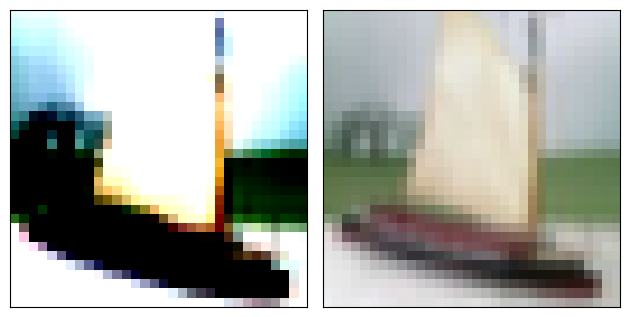

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

def preview_augmentations(train_loader, image_transform):
    batch_data, batch_label = next(iter(train_loader))
    preview_img = np.asarray(batch_data[0].squeeze())
    #preview_img = (preview_img*255./np.max(preview_img)).astype('uint8')
    preview_label = batch_label[0]
    fig, axs = plt.subplots(1, 2)
    plt.tight_layout()
    un_normalize_transform = transforms.Compose([transforms.Normalize((0.,0.,0.,),(1./0.247,1./0.244,1./0.262)),
                                                 transforms.Normalize((-0.491,-0.482,-0.447),(1.0,1.0,1.0))])
    un_normalized_img = un_normalize_transform(batch_data[0].squeeze())
    un_normalized_img = np.asarray(un_normalized_img)
    print(un_normalized_img.shape)
    transformed_numpy_img = image_transform(image = un_normalized_img)["image"]
    #transformed_numpy_img = (transformed_numpy_img*255./np.max(transformed_numpy_img)).astype('uint8')
    axs[0].imshow(preview_img.transpose((1,2,0)))
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].imshow(transformed_numpy_img.transpose((1,2,0)))
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    plt.tight_layout()
    plt.show()

img_transforms = A.Compose([AA.crops.transforms.RandomResizedCrop(height= 32,width = 32,p=0.5)])
preview_augmentations(train_loader, img_transforms)

Show sample Images from the dataset

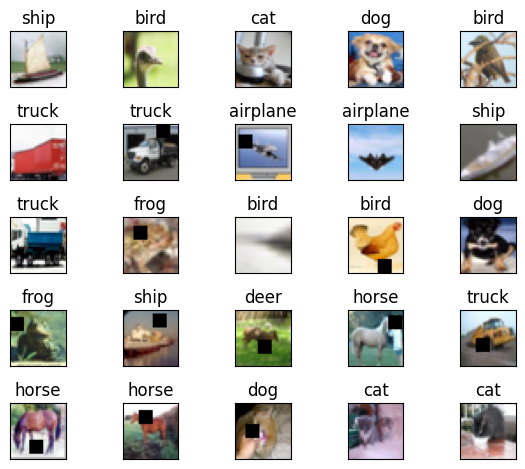

In [ ]:
preview_images(train_loader,class_names, num_rows = 5, num_cols = 5)

Train model using Batch Normalization

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.65E-02


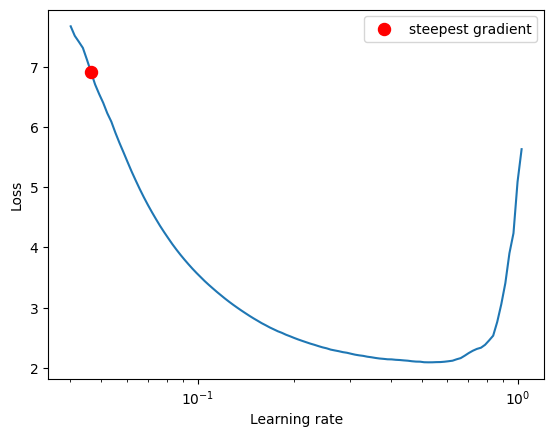

In [7]:
drop_out = 0.02
num_epochs=24
resnet_model = CustomResnet(base_channels=3, num_classes=10,drop_out_probability=drop_out).to(device)
criterion = nn.CrossEntropyLoss(reduction='mean')
optim_obj = Optimization(resnet_model, device, train_loader, criterion, num_epochs)
lr_history = find_best_lr(resnet_model, train_loader, optim_obj.optimizer, criterion, device)


In [8]:
from torch.optim.lr_scheduler import OneCycleLR
#optim_obj.define_scheduler(max_lr=4.93E-2)
train_losses = []
test_losses = []
train_acc = []
test_acc = []
lr_values = []
def define_scheduler(max_lr):
    scheduler = OneCycleLR(
        optim_obj.optimizer,
        max_lr = max_lr,
        steps_per_epoch=len(optim_obj.train_loader),
        epochs = num_epochs,
        pct_start = 5./num_epochs,
        div_factor=2000,
        three_phase=False,
        final_div_factor= 100,
        anneal_strategy='linear',
        verbose=False
        )
    return scheduler

max_lr = 4.65e-2
optim_obj.scheduler = define_scheduler(max_lr)

for epoch in range(1,num_epochs+1):
    lr_values.append(optim_obj.scheduler.get_lr())
    print(f"epoch: {epoch}\t learning rate: {optim_obj.scheduler.get_last_lr()[0]}")
    this_train_loss = training_loop(resnet_model, device, train_loader, optim_obj.optimizer, optim_obj.scheduler, criterion, train_acc, train_losses)
    this_loss = model_test(resnet_model, device, test_loader, criterion, test_acc, test_losses)
    #optim_obj.scheduler.step()



/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:1699: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


epoch: 1	 learning rate: 2.325e-05


  0%|          | 0/98 [00:00<?, ?it/s]/content/ERA_V1/session_10/custom_resnet/custom_resnet.py:161: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
loss=1.2853041887283325 batch_id=97 Accuracy = 43.85: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]



Test set: Average loss: 0.0029, Accuracy: 5096/10000 (50.96%)

epoch: 2	 learning rate: 0.009337608895705521


loss=1.0872119665145874 batch_id=97 Accuracy = 58.22: 100%|██████████| 98/98 [00:25<00:00,  3.79it/s]



Test set: Average loss: 0.0023, Accuracy: 6134/10000 (61.34%)

epoch: 3	 learning rate: 0.01865196779141104


loss=0.8282710313796997 batch_id=97 Accuracy = 66.34: 100%|██████████| 98/98 [00:25<00:00,  3.85it/s]



Test set: Average loss: 0.0020, Accuracy: 6683/10000 (66.83%)

epoch: 4	 learning rate: 0.02796632668711656


loss=0.7355738282203674 batch_id=97 Accuracy = 70.84: 100%|██████████| 98/98 [00:25<00:00,  3.80it/s]



Test set: Average loss: 0.0017, Accuracy: 7024/10000 (70.24%)

epoch: 5	 learning rate: 0.03728068558282208


loss=0.9159882068634033 batch_id=97 Accuracy = 71.16: 100%|██████████| 98/98 [00:25<00:00,  3.82it/s]



Test set: Average loss: 0.0018, Accuracy: 7009/10000 (70.09%)

epoch: 6	 learning rate: 0.046475026977712136


loss=0.8334195017814636 batch_id=97 Accuracy = 71.72: 100%|██████████| 98/98 [00:25<00:00,  3.85it/s]



Test set: Average loss: 0.0021, Accuracy: 6529/10000 (65.29%)

epoch: 7	 learning rate: 0.04402767079350161


loss=0.6946820020675659 batch_id=97 Accuracy = 73.02: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]



Test set: Average loss: 0.0020, Accuracy: 6685/10000 (66.85%)

epoch: 8	 learning rate: 0.04158031460929108


loss=0.7921945452690125 batch_id=97 Accuracy = 73.48: 100%|██████████| 98/98 [00:25<00:00,  3.86it/s]



Test set: Average loss: 0.0016, Accuracy: 7313/10000 (73.13%)

epoch: 9	 learning rate: 0.039132958425080556


loss=0.753044843673706 batch_id=97 Accuracy = 73.74: 100%|██████████| 98/98 [00:25<00:00,  3.84it/s]



Test set: Average loss: 0.0015, Accuracy: 7400/10000 (74.00%)

epoch: 10	 learning rate: 0.03668560224087003


loss=0.6739223599433899 batch_id=97 Accuracy = 74.93: 100%|██████████| 98/98 [00:25<00:00,  3.87it/s]



Test set: Average loss: 0.0015, Accuracy: 7327/10000 (73.27%)

epoch: 11	 learning rate: 0.0342382460566595


loss=0.7275983095169067 batch_id=97 Accuracy = 75.26: 100%|██████████| 98/98 [00:25<00:00,  3.87it/s]



Test set: Average loss: 0.0014, Accuracy: 7518/10000 (75.18%)

epoch: 12	 learning rate: 0.03179088987244898


loss=0.7459059953689575 batch_id=97 Accuracy = 75.47: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]



Test set: Average loss: 0.0014, Accuracy: 7643/10000 (76.43%)

epoch: 13	 learning rate: 0.029343533688238454


loss=0.8378145098686218 batch_id=97 Accuracy = 76.47: 100%|██████████| 98/98 [00:25<00:00,  3.89it/s]



Test set: Average loss: 0.0014, Accuracy: 7681/10000 (76.81%)

epoch: 14	 learning rate: 0.026896177504027927


loss=0.7746394276618958 batch_id=97 Accuracy = 77.05: 100%|██████████| 98/98 [00:25<00:00,  3.89it/s]



Test set: Average loss: 0.0012, Accuracy: 7938/10000 (79.38%)

epoch: 15	 learning rate: 0.0244488213198174


loss=0.6081660389900208 batch_id=97 Accuracy = 77.70: 100%|██████████| 98/98 [00:25<00:00,  3.89it/s]



Test set: Average loss: 0.0011, Accuracy: 8071/10000 (80.71%)

epoch: 16	 learning rate: 0.022001465135606874


loss=0.6599371433258057 batch_id=97 Accuracy = 78.28: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]



Test set: Average loss: 0.0015, Accuracy: 7550/10000 (75.50%)

epoch: 17	 learning rate: 0.01955410895139635


loss=0.5759057402610779 batch_id=97 Accuracy = 79.24: 100%|██████████| 98/98 [00:25<00:00,  3.91it/s]



Test set: Average loss: 0.0013, Accuracy: 7813/10000 (78.13%)

epoch: 18	 learning rate: 0.017106752767185825


loss=0.6469888091087341 batch_id=97 Accuracy = 80.02: 100%|██████████| 98/98 [00:25<00:00,  3.88it/s]



Test set: Average loss: 0.0010, Accuracy: 8259/10000 (82.59%)

epoch: 19	 learning rate: 0.014659396582975291


loss=0.6215744018554688 batch_id=97 Accuracy = 80.92: 100%|██████████| 98/98 [00:25<00:00,  3.91it/s]



Test set: Average loss: 0.0010, Accuracy: 8359/10000 (83.59%)

epoch: 20	 learning rate: 0.012212040398764772


loss=0.5460179448127747 batch_id=97 Accuracy = 82.52: 100%|██████████| 98/98 [00:25<00:00,  3.91it/s]



Test set: Average loss: 0.0010, Accuracy: 8301/10000 (83.01%)

epoch: 21	 learning rate: 0.009764684214554245


loss=0.45135483145713806 batch_id=97 Accuracy = 84.13: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]



Test set: Average loss: 0.0009, Accuracy: 8437/10000 (84.37%)

epoch: 22	 learning rate: 0.0073173280303437185


loss=0.35858213901519775 batch_id=97 Accuracy = 85.74: 100%|██████████| 98/98 [00:25<00:00,  3.91it/s]



Test set: Average loss: 0.0008, Accuracy: 8640/10000 (86.40%)

epoch: 23	 learning rate: 0.004869971846133192


loss=0.38468462228775024 batch_id=97 Accuracy = 87.85: 100%|██████████| 98/98 [00:25<00:00,  3.90it/s]



Test set: Average loss: 0.0006, Accuracy: 8933/10000 (89.33%)

epoch: 24	 learning rate: 0.0024226156619226655


loss=0.24488136172294617 batch_id=97 Accuracy = 90.30: 100%|██████████| 98/98 [00:25<00:00,  3.89it/s]



Test set: Average loss: 0.0006, Accuracy: 9031/10000 (90.31%)



Plot LR values

In [9]:
import matplotlib.pyplot as plt
def plot_lr_values2(lr_list):
    num_epochs = len(lr_list)
    plt.figure()
    plt.plot(range(1,num_epochs+1),lr_list)
    plt.xlabel('Epoch #')
    plt.ylabel("Learning Rate")
    #plt.yscale('log')
    plt.show()

def plot_lr_values(scheduler, num_epochs, num_batches):
    lrs = []
    steps = []
    for epoch in range(num_epochs):
        for batch in range(num_batches):
            scheduler.step()
            lrs.append(scheduler.get_last_lr()[0])
            steps.append(epoch * num_batches + batch)

    plt.figure()
    plt.legend()
    plt.plot(steps, lrs, label='OneCycle')
    plt.show()

def plot_losses(train_losses, test_losses):
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    epochs = range(1,len(train_losses)+1)
    axs[0].plot(epochs, train_losses)
    axs[0].set_title("Train")
    axs[1].plot(epochs, test_losses)
    axs[1].set_title("Test")

def plot_accuracy(train_acc, test_acc, target_test_acc = 90.):
    epochs = range(1,len(train_acc)+1)
    plt.figure()
    plt.plot(epochs, train_acc, epochs, test_acc)
    plt.axhline(target_test_acc, color='r')
    plt.legend(('Train','Test'),loc='best')
    plt.title("Accuracy")


Plot results for Batch Norm experiment

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


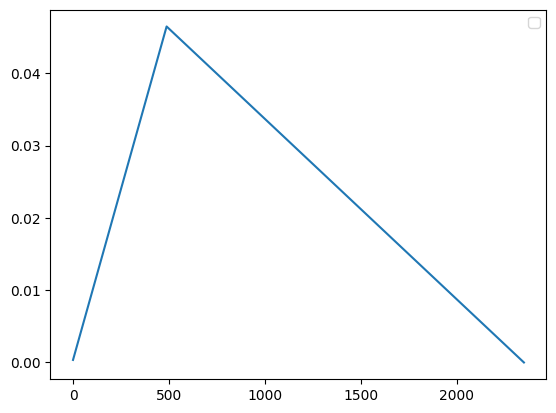

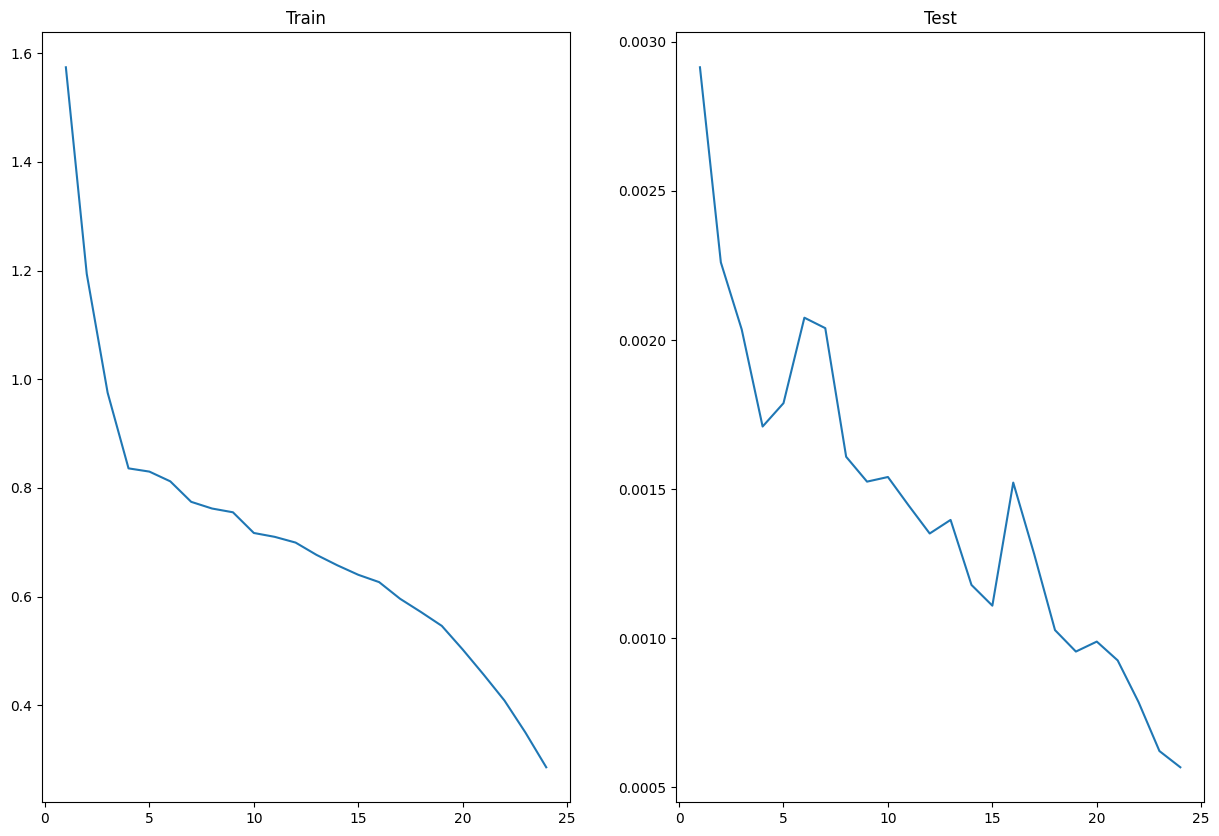

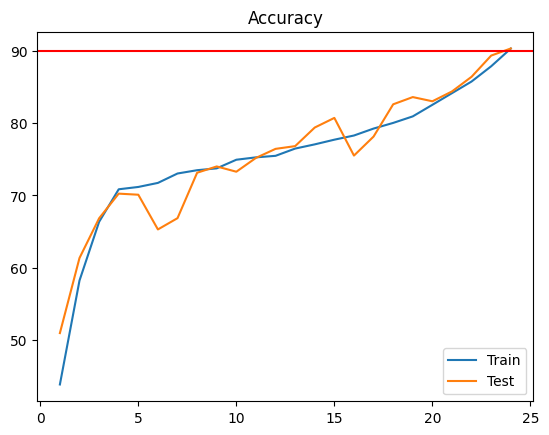

In [10]:
this_scheduler = OneCycleLR(
        optim_obj.optimizer,
        max_lr = max_lr,
        steps_per_epoch=len(optim_obj.train_loader),
        epochs = num_epochs,
        pct_start = 5./num_epochs,
        div_factor=200,
        three_phase=False,
        #final_div_factor=1000,
        anneal_strategy='linear',
        verbose=False
        )
plot_lr_values(this_scheduler, num_epochs, len(train_loader))
plot_losses(train_losses, test_losses)
plot_accuracy(train_acc, test_acc, target_test_acc=90.)


Print Training Log

In [11]:
print_train_log(train_acc, test_acc, train_losses, test_losses)

+-------+---------------------+-----------------------+----------------+--------------+
| Epoch |      Train loss     |        Val loss       | Train Accuracy | Val Accuracy |
+-------+---------------------+-----------------------+----------------+--------------+
|   1   |  1.5742168827932708 | 0.0029146114587783813 |     43.854     |    50.96     |
|   2   |  1.1938890224816847 | 0.0022604991614818574 |     58.224     |    61.34     |
|   3   |  0.9751202147834155 | 0.0020353579759597776 |     66.34      |    66.83     |
|   4   |  0.8359070256048319 | 0.0017099724173545838 |     70.842     |    70.24     |
|   5   |  0.8299364003599906 | 0.0017883456230163575 |     71.164     |    70.09     |
|   6   |  0.8120121566616759 |  0.002074887454509735 |     71.724     |    65.29     |
|   7   |  0.7742981107867494 | 0.0020398482739925386 |     73.024     |    66.85     |
|   8   |  0.7619756192577128 | 0.0016085849463939666 |     73.48      |    73.13     |
|   9   |  0.755055057150977  | 